In [5]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score

# Function to calculate NMI between two matrices
def calculate_nmi_sklearn(matrix1, matrix2):
    """
    Calculates the Normalized Mutual Information (NMI) between two matrices.

    Args:
        matrix1 (np.array): First matrix.
        matrix2 (np.array): Second matrix.

    Returns:
        float: NMI score.
    """
    # Flatten the matrices to obtain discrete labels for comparison
    flattened_matrix1 = matrix1.flatten()
    flattened_matrix2 = matrix2.flatten()

    # Calculate the NMI
    nmi_score = normalized_mutual_info_score(flattened_matrix1, flattened_matrix2)

    return nmi_score

# Example matrices
S1 = np.array([[0.5, 0.2, 0.3], [0.4, 0.1, 0.6], [0.7, 0.2, 0.5]])
S2 = np.array([[0.4, 0.3, 0.3], [0.5, 0.1, 0.7], [0.6, 0.3, 0.5]])

# Calculate the NMI between the two example matrices
nmi = calculate_nmi_sklearn(S1, S2)

print(f"NMI between the given matrices: {nmi:.2f}")


NMI between the given matrices: 0.85


c:\Users\augus\miniconda3\envs\spyder-cf\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [14]:
import numpy as np

# Generate two synthetic S matrices with columns summing to 1
np.random.seed(0)  # For reproducibility

# Create synthetic S matrices with 5 rows and 3 columns
S1 = np.random.rand(5, 3)
S2 = np.random.rand(5, 3)

# Normalize each column to sum to 1
S1 /= S1.sum(axis=0, keepdims=True)
S2 /= S2.sum(axis=0, keepdims=True)

# Sum of each column should be 1
print(f"Sum of each column in S1: {S1.sum(axis=0)}")

display(S1, S2)


Sum of each column in S1: [1. 1. 1.]


array([[0.22104887, 0.19082205, 0.21433483],
       [0.21946583, 0.11303674, 0.22967156],
       [0.1762496 , 0.23793691, 0.34266596],
       [0.15444102, 0.21124278, 0.18806816],
       [0.22879468, 0.24696151, 0.0252595 ]])

array([[0.03194606, 0.00804399, 0.26434201],
       [0.28531209, 0.34613858, 0.31069393],
       [0.29301243, 0.18360182, 0.24780414],
       [0.04336546, 0.2545957 , 0.04551212],
       [0.34636397, 0.2076199 , 0.1316478 ]])

In [15]:
# Define a function to calculate NMI
def calculate_MI(S1, S2):
    """
    Calculate the joint distribution p(d, d') from two matrices.
    """
    
    # Calculate p(d, d') as the dot product between S1 and S2 transpose (normalized)
    prob = S1@S2.T

    # Normalize joint distribution to ensure it sums to 1
    prob_XY = prob/np.sum(prob)

    # Calculate marginal distributions
    prob_X_Y = np.outer(np.sum(prob_XY, axis=1), np.sum(prob_XY, axis=0))
    
    # Calculate mutual information
    MI = np.sum(prob_XY * np.log(prob_XY / prob_X_Y))

    return MI

def calculate_NMI(S1, S2):
    """
    Calculate the Normalized Mutual Information (NMI) between two matrices.
    """
    # Calculate NMI
    NMI = 2 * calculate_MI(S1,S2) / (calculate_MI(S1, S1) + calculate_MI(S2,S2))
    
    return NMI

# Calculate the NMI between the two synthetic S matrices
nmi_result = calculate_NMI(S1, S2)

nmi_result  # Normalized Mutual Information between S1 and S2


0.8610299143818321

In [8]:
calculate_nmi_sklearn(S1, S2)

c:\Users\augus\miniconda3\envs\spyder-cf\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


1.0

In [11]:
# From data import S.npy
import numpy as np

# Load the S matrix from the file
S = np.load(r'sleepy_mice\src\data\S.npy')
S1 = np.load(r'sleepy_mice\src\data\S1.npy')

calculate_NMI(S, S1), calculate_nmi_sklearn(S, S1)

c:\Users\augus\miniconda3\envs\spyder-cf\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


(1.0, 1.0)

In [27]:
print(S.sum(axis=0), S1.sum(axis=0))

[1. 1. 1. ... 1. 1. 1.] [1. 1. 1. ... 1. 1. 1.]


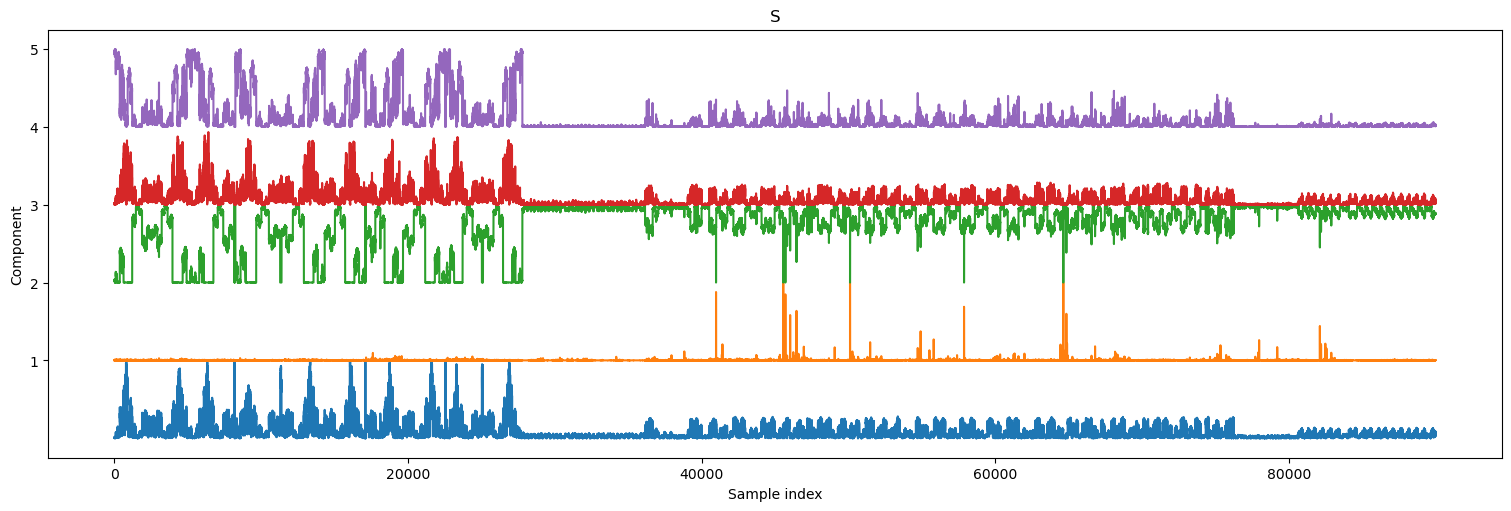

In [30]:
K=5
fig, axs = plt.subplots(1,1,figsize=(15,5),layout='constrained')
for k in range(K):
    axs.plot(S[k,:]+k)
axs.set_title('S')
axs.set_yticks([k+1 for k in range(K)])
axs.set_yticklabels([k+1 for k in range(K)])
axs.set_ylabel('Component')
axs.set_xlabel('Sample index')

plt.show()

In [16]:
# Test NMI